In [1]:
import qiskit
import numpy as np

import json, glob, math

In [2]:
glob.glob("*")

['elephant QFT-Copy1.ipynb',
 'elephant QFT.ipynb',
 'main.py',
 'plot-tools.py',
 'PlotTools.py',
 'png-tools.py',
 'QHOMER_IQFT.ipynb',
 'QHOMER_Optimizer_Function_FIXED.ipynb',
 'README.md',
 'Resources',
 'VectorQraphics.py',
 '__pycache__']

In [3]:
def qubits_necessary(n):
    """log2 of n"""
    l2 = math.log2(n)
    assert l2 % 1 == 0, "not an integer power of 2"
    return int(l2)

def normalized(arr):
    """l2-normalization"""
    return arr / np.linalg.norm(arr, 2)

## Data Loading

In [61]:
with open("./Resources/elephant.9.json") as f:
    data = json.load(f)[:-1]
    data = normalized(np.array([complex(a, b) for a, b in data]))
    #data = np.round(data, 2)

In [62]:
data

array([-4.35901392e-02-2.65964437e-02j, -4.30989399e-02-2.43032451e-02j,
       -4.21365480e-02-2.18784285e-02j, -4.07376315e-02-1.94407436e-02j,
       -3.89983016e-02-1.71145941e-02j, -3.70717877e-02-1.50174593e-02j,
       -3.51537258e-02-1.32498021e-02j, -3.34587941e-02-1.18887136e-02j,
       -3.21922180e-02-1.09855860e-02j, -3.15208428e-02-1.05671859e-02j,
       -3.15487582e-02-1.06388453e-02j, -3.23017958e-02-1.11882286e-02j,
       -3.37237046e-02-1.21883188e-02j, -3.56847498e-02-1.35988126e-02j,
       -3.80012661e-02-1.53658697e-02j, -4.04627661e-02-1.74208972e-02j,
       -4.28619336e-02-1.96795844e-02j, -4.50224513e-02-2.20425608e-02j,
       -4.68201795e-02-2.43987958e-02j, -4.81945861e-02-2.66322352e-02j,
       -4.91492180e-02-2.86313277e-02j, -4.97420335e-02-3.03002401e-02j,
       -5.00681621e-02-3.15699209e-02j, -5.02388143e-02-3.24069004e-02j,
       -5.03604281e-02-3.28179307e-02j, -5.05176951e-02-3.28492151e-02j,
       -5.07630058e-02-3.25799562e-02j, -5.11133592

## Classical FT

In [63]:
data_ft = normalized(np.fft.fft(data))

In [64]:
data_ft

array([ 3.11258564e-17-4.90653893e-18j, -3.37874001e-01+7.47997690e-03j,
       -6.93244395e-02+6.99712373e-02j,  7.38524462e-02-4.41176086e-03j,
       -1.31627866e-01-4.03124628e-03j,  5.07816602e-02-4.31930322e-02j,
       -4.08999833e-02+4.54153386e-02j, -4.50729943e-02-5.70090613e-02j,
        9.02775877e-02-3.06749255e-02j,  9.38907158e-02+2.37480098e-02j,
        2.15311941e-02+6.78974482e-03j,  1.90902952e-02-2.27057997e-03j,
        2.17260520e-02-2.51028074e-02j, -2.92489251e-02+2.69579732e-02j,
       -2.71478456e-03+1.04973561e-02j,  2.76370473e-02+9.12988088e-03j,
       -1.62827947e-02-3.84878235e-03j,  6.94553500e-03+6.01296575e-03j,
        2.65215286e-02-2.15030372e-02j, -1.03744162e-02-2.54647181e-02j,
       -1.90117478e-03-3.68811405e-04j, -2.67136463e-03-7.79200223e-03j,
       -5.78018426e-03-5.66150407e-03j, -1.23842967e-02+1.07669843e-02j,
        1.27200044e-03+3.17919678e-03j, -1.43765420e-03-8.36163547e-03j,
        1.92294095e-03-1.11202931e-02j, -9.72996792

## State Loading

In [65]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute

In [66]:
def to_statevector(self):
    job = execute(self, Aer.get_backend("statevector_simulator"))
    return job.result().get_statevector()

QuantumCircuit.to_statevector = to_statevector

In [67]:
def QHomer_Init(data_ft):
    """creates an initialization circuit creating a state with data_ft as coefficients"""
    # number of qubits necessary
    qubit_count = qubits_necessary(len(data_ft))
    #print(f"need {qubit_count} qubits")

    # quantum and classical registers
    qregs = QuantumRegister(qubit_count)
    cregs = ClassicalRegister(qubit_count)

    # array of complex amplitudes
    desired_state = data_ft

    # initialization circut
    circuit = QuantumCircuit(qregs, name="data_loader_trivial")
    circuit.initialize(desired_state, range(qubit_count))
    
    return circuit

## Inverse QFT

In [68]:
def QHomer_IQFT(circuit):
    from qiskit.aqua.components.iqfts.standard import Standard as StandardIQFT

    IQFT = StandardIQFT(len(circuit.qubits))
    iqft = IQFT.construct_circuit(mode="circuit", qubits=circuit.qubits, circuit=circuit)

    return iqft


## Simulate and Measure

In [69]:
from qiskit.ignis.verification.tomography import StateTomographyFitter, state_tomography_circuits

In [70]:
statevector_after_iqft = None

def QHomer_Cheap_Mans_Tomography(data_ft, cheat=True):
    simulator = Aer.get_backend("qasm_simulator")
    n_qubits = qubits_necessary(len(data_ft))
    
    circuit_init = QHomer_Init(data_ft)
    circuit_iqft = QHomer_IQFT(circuit_init)
    
    global statevector_after_iqft
    statevector_after_iqft = circuit_iqft.to_statevector()
    
    if cheat:
        return statevector_after_iqft
    
    # full tomography    
    measured_qubits = circuit_iqft.qubits
    tomography_circuits = state_tomography_circuits(circuit_iqft, measured_qubits)
    
    tomography_results = StateTomographyFitter(execute(
            tomography_circuits,
            Aer.get_backend('qasm_simulator'),
            shots=10000
        ).result(),
        tomography_circuits
    ).fit('cvx')
    
    rho = np.array(tomography_results)
    evals, evecs = np.linalg.eig(rho)
    tomography_guess = evecs[np.argmax(np.abs(evals))]
    return tomography_guess

In [71]:
phase_tomography_results = QHomer_Cheap_Mans_Tomography(data_ft)

## Recreate Original

In [72]:
from PlotTools import plot

In [73]:
import functools

In [74]:
xs, ys = np.real(phase_tomography_results), np.imag(phase_tomography_results)
xs

array([-4.35901392e-02, -4.36311697e-02, -4.32850886e-02, -4.26389131e-02,
       -4.17851493e-02, -4.08066090e-02, -3.97671152e-02, -3.87091393e-02,
       -3.76577324e-02, -3.66286971e-02, -3.56380878e-02, -3.47100054e-02,
       -3.38802604e-02, -3.31946542e-02, -3.27020863e-02, -3.24440812e-02,
       -3.24433265e-02, -3.26941884e-02, -3.31578340e-02, -3.37636262e-02,
       -3.44170744e-02, -3.50131426e-02, -3.54524679e-02, -3.56573048e-02,
       -3.55839577e-02, -3.52291074e-02, -3.46286454e-02, -3.38491462e-02,
       -3.29736030e-02, -3.20842251e-02, -3.12456819e-02, -3.04920834e-02,
       -2.98202190e-02, -2.91903154e-02, -2.85340817e-02, -2.77683932e-02,
       -2.68119158e-02, -2.56014761e-02, -2.41051361e-02, -2.23296625e-02,
       -2.03212306e-02, -1.81595133e-02, -1.59465164e-02, -1.37923974e-02,
       -1.18008873e-02, -1.00567996e-02, -8.61750720e-03, -7.50936417e-03,
       -6.72905181e-03, -6.24893717e-03, -6.02492447e-03, -6.00504012e-03,
       -6.13713119e-03, -

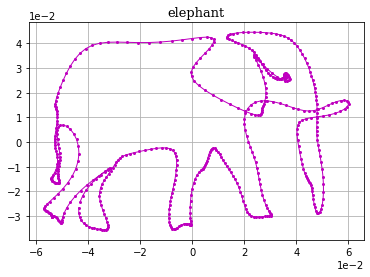

In [75]:
plot("elephant", xs, ys, linestyle="-")